In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix
)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import matplotlib.image as mpimg
from PIL import Image
from tensorflow.keras.layers import RandomFlip, RandomRotation
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from joblib import dump

In [3]:
# Root dataset directory
path = r"G:\final\ALZHEMERS\Combined Dataset"

# Classes in your dataset
categories = ["Mild Impairment", 
           "Moderate Impairment", 
           "No Impairment", 
           "Very Mild Impairment"]

# Expected "train" and "test" folders inside root
train_dir = os.path.join(path, "train")
test_dir  = os.path.join(path, "test")

# Function to define and display category paths
def define_dirs(base_dir, dataset_name):
    print(f"\n{dataset_name.upper()} dataset directories:")
    dirs = {}
    if not os.path.exists(base_dir):
        print(f"❌ {dataset_name} directory NOT found:", base_dir)
        return None

    for cls in categories:
        cls_path = os.path.join(base_dir, cls)
        dirs[cls] = cls_path
        if os.path.exists(cls_path):
            print(f"✅ {cls}: {cls_path}")
        else:
            print(f"❌ Missing folder → {cls}: {cls_path}")

    return dirs

# Display folder structure
train_dirs = define_dirs(train_dir, "Train")
test_dirs  = define_dirs(test_dir, "Test")


TRAIN dataset directories:
✅ Mild Impairment: G:\final\ALZHEMERS\Combined Dataset\train\Mild Impairment
✅ Moderate Impairment: G:\final\ALZHEMERS\Combined Dataset\train\Moderate Impairment
✅ No Impairment: G:\final\ALZHEMERS\Combined Dataset\train\No Impairment
✅ Very Mild Impairment: G:\final\ALZHEMERS\Combined Dataset\train\Very Mild Impairment

TEST dataset directories:
✅ Mild Impairment: G:\final\ALZHEMERS\Combined Dataset\test\Mild Impairment
✅ Moderate Impairment: G:\final\ALZHEMERS\Combined Dataset\test\Moderate Impairment
✅ No Impairment: G:\final\ALZHEMERS\Combined Dataset\test\No Impairment
✅ Very Mild Impairment: G:\final\ALZHEMERS\Combined Dataset\test\Very Mild Impairment


In [4]:
# Function to verify if directories exist
def verify_directories(dirs, dataset_name):
    print(f"\nVerifying {dataset_name} directories:")
    if dirs is None:
        print(f"❌ No directories found for {dataset_name}.")
        return

    for category, path in dirs.items():
        if os.path.exists(path):
            print(f"✅ Directory exists: {path}")
        else:
            print(f"❌ Directory NOT found: {path}")


# Verify Train directories
verify_directories(train_dirs, "Train")

# Verify Test directories
verify_directories(test_dirs, "Test")

# No VALID folder in your dataset → REMOVE this check
print("\nValidation dataset does NOT exist in your dataset structure.")
print("✔ Skipping 'valid_dirs' verification.")


Verifying Train directories:
✅ Directory exists: G:\final\ALZHEMERS\Combined Dataset\train\Mild Impairment
✅ Directory exists: G:\final\ALZHEMERS\Combined Dataset\train\Moderate Impairment
✅ Directory exists: G:\final\ALZHEMERS\Combined Dataset\train\No Impairment
✅ Directory exists: G:\final\ALZHEMERS\Combined Dataset\train\Very Mild Impairment

Verifying Test directories:
✅ Directory exists: G:\final\ALZHEMERS\Combined Dataset\test\Mild Impairment
✅ Directory exists: G:\final\ALZHEMERS\Combined Dataset\test\Moderate Impairment
✅ Directory exists: G:\final\ALZHEMERS\Combined Dataset\test\No Impairment
✅ Directory exists: G:\final\ALZHEMERS\Combined Dataset\test\Very Mild Impairment

Validation dataset does NOT exist in your dataset structure.
✔ Skipping 'valid_dirs' verification.


In [5]:
# Function to count the number of valid image files in each category
def count_images_in_categories(dirs):
    image_counts = {}
    
    for category, path in dirs.items():
        if os.path.exists(path):
            # Only count image files
            image_files = [
                f for f in os.listdir(path)
                if f.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"))
            ]
            image_counts[category] = len(image_files)
        else:
            image_counts[category] = 0  # directory missing

    return image_counts


# Count images in train and test directories
train_image_counts = count_images_in_categories(train_dirs)
test_image_counts = count_images_in_categories(test_dirs)

# Display image counts for each dataset
print("\nTrain Image Counts:")
print(train_image_counts)

print("\nTest Image Counts:")
print(test_image_counts)

print("\nNo VALID dataset present in your structure — skipping valid counts.")


Train Image Counts:
{'Mild Impairment': 2560, 'Moderate Impairment': 2560, 'No Impairment': 2560, 'Very Mild Impairment': 2560}

Test Image Counts:
{'Mild Impairment': 179, 'Moderate Impairment': 12, 'No Impairment': 640, 'Very Mild Impairment': 448}

No VALID dataset present in your structure — skipping valid counts.



Displaying sample images from Train dataset...



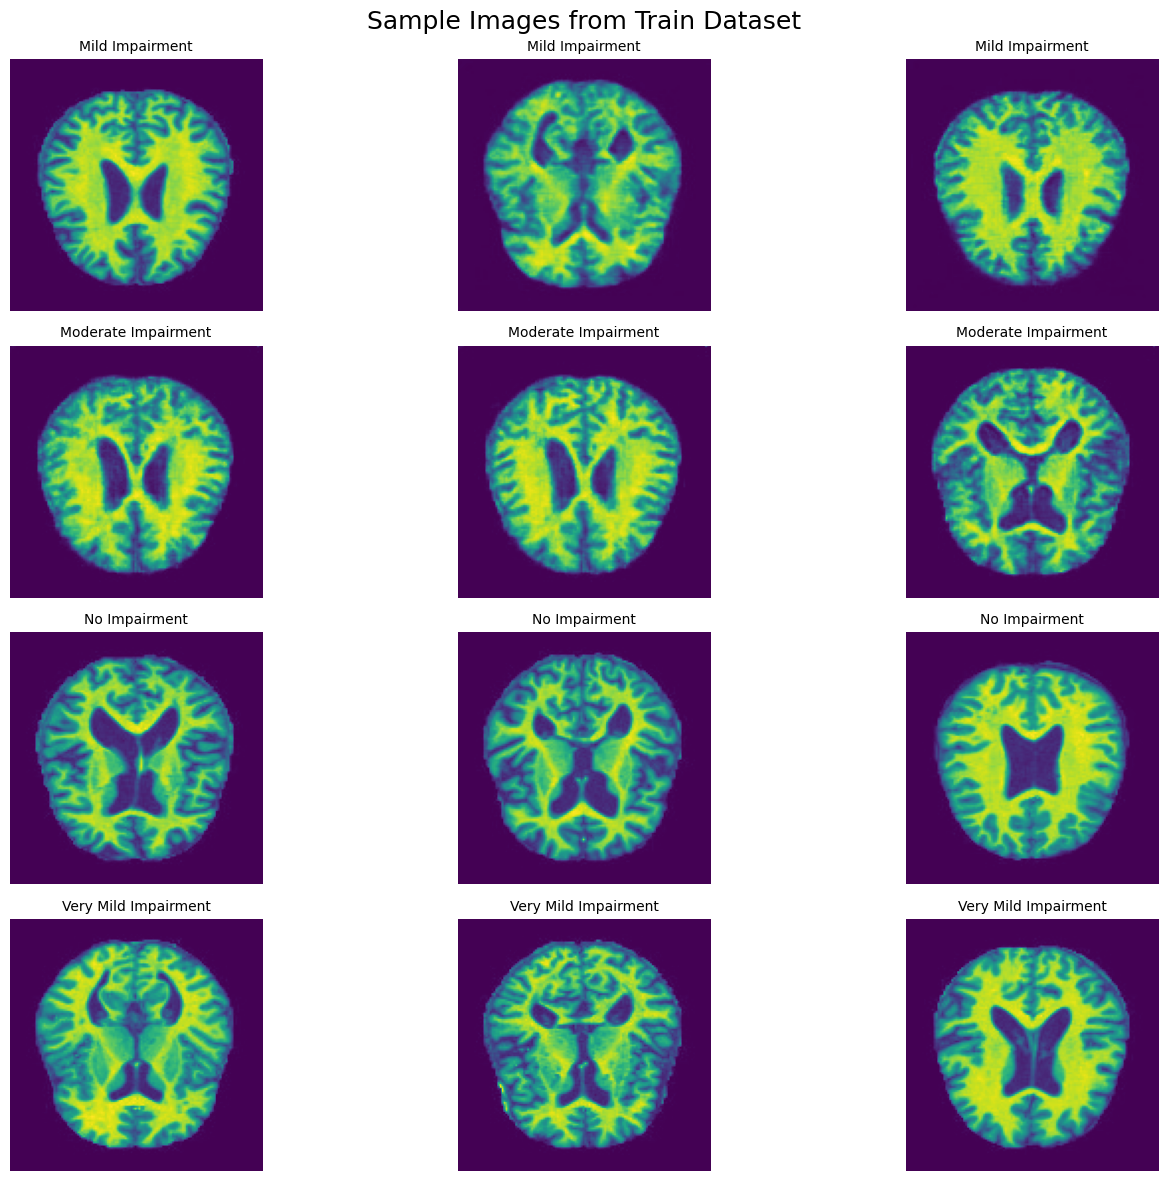


Displaying sample images from Test dataset...



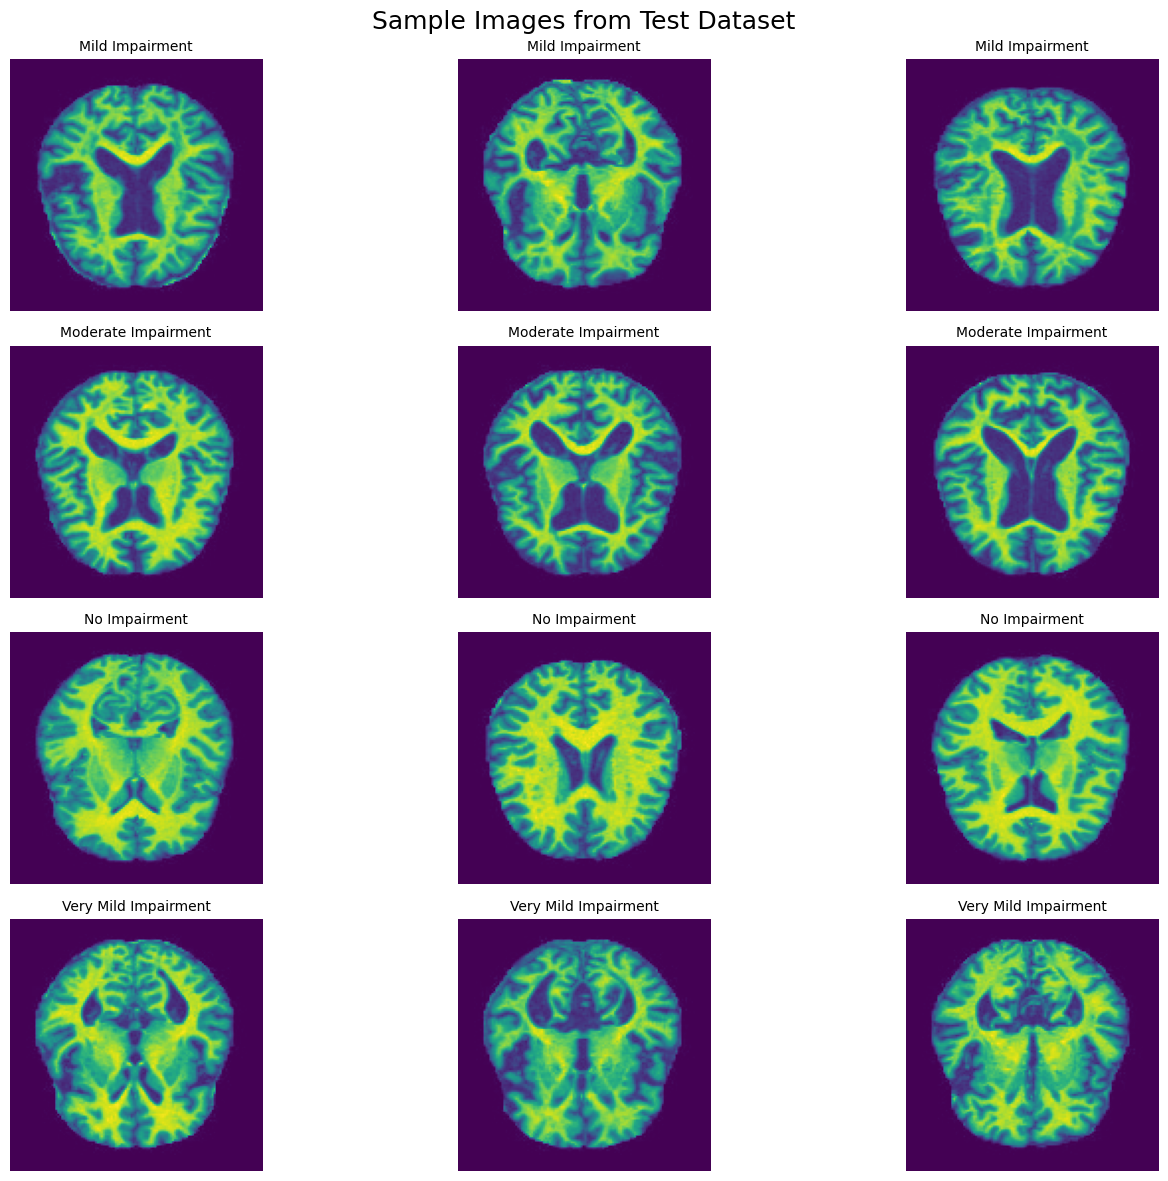


No VALID dataset present — skipping valid sample display.



In [6]:
# Number of images to show per class
samples_per_class = 3

def display_sample_images(dirs, dataset_type):
    print(f"\nDisplaying sample images from {dataset_type} dataset...\n")
    
    plt.figure(figsize=(15, 12))
    img_num = 1
    
    for category in categories:
        folder = dirs[category]
        
        if not os.path.exists(folder):
            print(f"❌ Folder missing: {folder}")
            continue
        
        # List only image files
        image_files = [
            f for f in os.listdir(folder)
            if f.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"))
        ]
        
        if len(image_files) == 0:
            print(f"⚠ No images found in {folder}")
            continue
        
        # Pick random images
        sample_images = random.sample(image_files, min(samples_per_class, len(image_files)))
        
        # Plot them
        for img_name in sample_images:
            img_path = os.path.join(folder, img_name)
            img = mpimg.imread(img_path)
            
            plt.subplot(len(categories), samples_per_class, img_num)
            plt.imshow(img)
            plt.title(category, fontsize=10)
            plt.axis("off")
            
            img_num += 1
    
    plt.suptitle(f"Sample Images from {dataset_type} Dataset", fontsize=18)
    plt.tight_layout()
    plt.show()


# Display sample images from TRAIN
display_sample_images(train_dirs, "Train")

# Display sample images from TEST
display_sample_images(test_dirs, "Test")

print("\nNo VALID dataset present — skipping valid sample display.\n")

In [7]:
# Checking image dimensions across categories
def check_image_dimensions(dirs, dataset_type):
    print(f"\nChecking image dimensions for {dataset_type} dataset:")
    
    dimensions = []

    for category, path in dirs.items():
        if not os.path.exists(path):
            print(f"❌ Path does not exist for {category}: {path}")
            continue

        # Get a list of image files in the directory
        image_files = [
            f for f in os.listdir(path)
            if f.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"))
        ]

        if len(image_files) == 0:
            print(f"⚠ No image files found in {category} folder: {path}")
            continue

        # Load the first image to check its dimensions
        image_path = os.path.join(path, image_files[0])
        try:
            img = Image.open(image_path)
            dimensions.append(img.size)  # (width, height)
            print(f"{category}: {img.size}")
        except Exception as e:
            print(f"⚠ Failed to open image in {category} ({image_path}): {e}")

    # Show unique dimension sizes summary
    unique_dims = set(dimensions)
    print(f"\nUnique image dimensions in {dataset_type} dataset: {unique_dims}\n")

    return dimensions


# Check image dimensions in TRAIN and TEST datasets only
train_image_dimensions = check_image_dimensions(train_dirs, 'Train')
test_image_dimensions = check_image_dimensions(test_dirs, 'Test')

print("No VALID dataset present in your structure — skipping 'Valid' check.")


Checking image dimensions for Train dataset:
Mild Impairment: (128, 128)
Moderate Impairment: (128, 128)
No Impairment: (128, 128)
Very Mild Impairment: (128, 128)

Unique image dimensions in Train dataset: {(128, 128)}


Checking image dimensions for Test dataset:
Mild Impairment: (128, 128)
Moderate Impairment: (128, 128)
No Impairment: (128, 128)
Very Mild Impairment: (128, 128)

Unique image dimensions in Test dataset: {(128, 128)}

No VALID dataset present in your structure — skipping 'Valid' check.


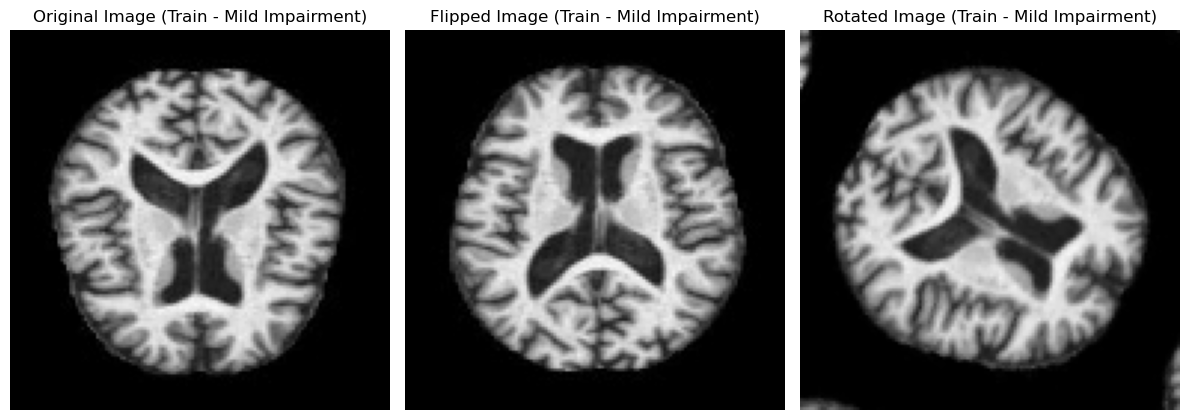

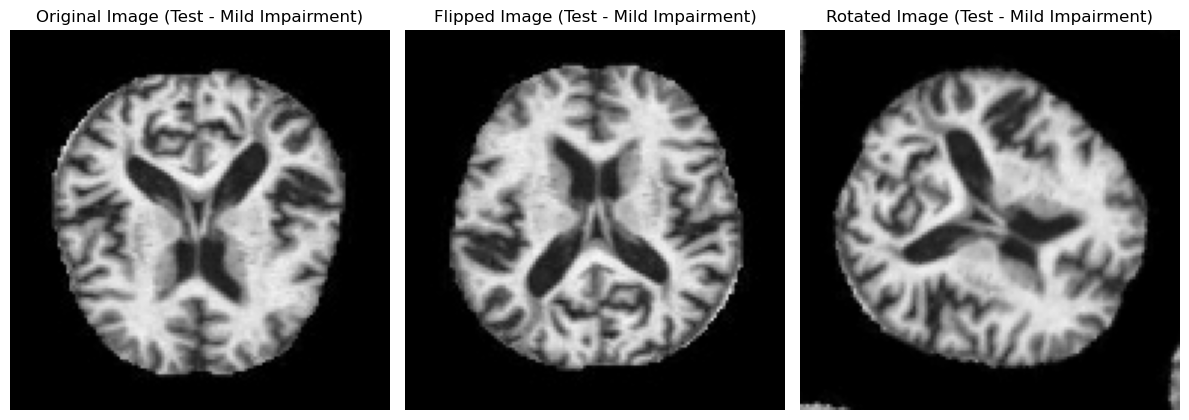

In [8]:
# Image augmentation (random flip and rotation)
def augment_images(sample_image_path, dataset_type):
    # Load image
    img = tf.keras.preprocessing.image.load_img(sample_image_path)
    img_array = tf.keras.preprocessing.image.img_to_array(img)

    plt.figure(figsize=(12, 6))

    # 1. Original image
    plt.subplot(1, 3, 1)
    plt.imshow(img_array.astype("uint8"))
    plt.title(f"Original Image ({dataset_type})")
    plt.axis("off")

    # 2. Random flip
    flip_layer = RandomFlip("horizontal_and_vertical")
    flipped_img = flip_layer(tf.expand_dims(img_array, 0))

    plt.subplot(1, 3, 2)
    plt.imshow(tf.squeeze(flipped_img).numpy().astype("uint8"))
    plt.title(f"Flipped Image ({dataset_type})")
    plt.axis("off")

    # 3. Random rotation
    rotate_layer = RandomRotation(0.2)
    rotated_img = rotate_layer(tf.expand_dims(img_array, 0))

    plt.subplot(1, 3, 3)
    plt.imshow(tf.squeeze(rotated_img).numpy().astype("uint8"))
    plt.title(f"Rotated Image ({dataset_type})")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


# Helper to pick a random image path from a given class
def get_random_image_path(dirs, category):
    folder = dirs[category]

    # Filter only image files
    image_files = [
        f for f in os.listdir(folder)
        if f.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"))
    ]

    if not image_files:
        raise FileNotFoundError(f"No image files found in: {folder}")

    img_name = random.choice(image_files)
    return os.path.join(folder, img_name)


# Choose one category to demonstrate augmentation on
sample_category = "Mild Impairment"  

# Train dataset
sample_image_path_train = get_random_image_path(train_dirs, sample_category)
augment_images(sample_image_path_train, f"Train - {sample_category}")

# Test dataset
sample_image_path_test = get_random_image_path(test_dirs, sample_category)
augment_images(sample_image_path_test, f"Test - {sample_category}")

In [9]:
# AUTOTUNE for better pipeline performance
AUTOTUNE = tf.data.AUTOTUNE

# Function to create a TensorFlow dataset with normalization
def create_normalized_dataset(base_dir, batch_size=32, image_size=(224, 224)):
    dataset = image_dataset_from_directory(
        base_dir,
        shuffle=True,
        batch_size=batch_size,
        image_size=image_size
    )
    
    # Normalize pixel values to [0, 1]
    normalization_layer = Rescaling(1.0 / 255.0)
    normalized_dataset = dataset.map(
        lambda x, y: (normalization_layer(x), y),
        num_parallel_calls=AUTOTUNE
    )
    
    return normalized_dataset

# Base train and test directories (already defined earlier)
# train_dir = os.path.join(path, "train")
# test_dir  = os.path.join(path, "test")

batch_size = 32
image_size = (224, 224)

# Create normalized datasets for train and test
train_dataset = create_normalized_dataset(train_dir, batch_size=batch_size, image_size=image_size)
test_dataset  = create_normalized_dataset(test_dir,  batch_size=batch_size, image_size=image_size)

# Optimize performance by prefetching
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset  = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Verifying dataset normalization by inspecting a sample
for images, labels in train_dataset.take(1):
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")
    print(f"Pixel range AFTER normalization: {tf.reduce_min(images).numpy():.4f} to {tf.reduce_max(images).numpy():.4f}")

Found 10240 files belonging to 4 classes.
Found 1279 files belonging to 4 classes.
Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)
Pixel range AFTER normalization: 0.0000 to 1.0000


In [10]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
image_size = (224, 224)

# ------------------------------------------------------------
# Helper: create normalized dataset from a directory
# ------------------------------------------------------------
def create_normalized_dataset(base_dir, batch_size=32, image_size=(224, 224)):
    ds = image_dataset_from_directory(
        base_dir,
        shuffle=True,
        batch_size=batch_size,
        image_size=image_size
    )

    norm_layer = Rescaling(1.0 / 255.0)
    ds = ds.map(lambda x, y: (norm_layer(x), y), num_parallel_calls=AUTOTUNE)
    return ds

# ------------------------------------------------------------
# Split a dataset into TRAIN and VALIDATION only (test is separate)
# ------------------------------------------------------------
def split_dataset(dataset, train_fraction=0.8, shuffle=True, seed=42):
    # Number of batches in the dataset
    ds_size = tf.data.experimental.cardinality(dataset).numpy()
    if ds_size <= 0:
        raise ValueError("Dataset appears to be empty or has unknown cardinality.")

    if shuffle:
        dataset = dataset.shuffle(buffer_size=ds_size, seed=seed, reshuffle_each_iteration=False)

    train_size = int(train_fraction * ds_size)

    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size)

    return train_ds, val_ds

# ------------------------------------------------------------
# Build datasets
# ------------------------------------------------------------

# 1) Full normalized dataset from TRAIN directory
full_train_ds = create_normalized_dataset(train_dir, batch_size=batch_size, image_size=image_size)

# 2) Split into train and validation
train_dataset, val_dataset = split_dataset(full_train_ds, train_fraction=0.8)

# 3) Separate TEST dataset from test_dir
test_dataset = create_normalized_dataset(test_dir, batch_size=batch_size, image_size=image_size)

# 4) Prefetch to optimize pipeline
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset   = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset  = test_dataset.prefetch(buffer_size=AUTOTUNE)

# ------------------------------------------------------------
# Verify splits and shapes
# ------------------------------------------------------------
print("Training Dataset batch example:")
for images, labels in train_dataset.take(1):
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Pixel range (train): {tf.reduce_min(images).numpy():.4f} to {tf.reduce_max(images).numpy():.4f}")
print()

print("Validation Dataset batch example:")
for images, labels in val_dataset.take(1):
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Pixel range (val): {tf.reduce_min(images).numpy():.4f} to {tf.reduce_max(images).numpy():.4f}")
print()

print("Test Dataset batch example:")
for images, labels in test_dataset.take(1):
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Pixel range (test): {tf.reduce_min(images).numpy():.4f} to {tf.reduce_max(images).numpy():.4f}")

Found 10240 files belonging to 4 classes.
Found 1279 files belonging to 4 classes.
Training Dataset batch example:
Images shape: (32, 224, 224, 3)
Labels shape: (32,)
Pixel range (train): 0.0000 to 1.0000

Validation Dataset batch example:
Images shape: (32, 224, 224, 3)
Labels shape: (32,)
Pixel range (val): 0.0000 to 1.0000

Test Dataset batch example:
Images shape: (32, 224, 224, 3)
Labels shape: (32,)
Pixel range (test): 0.0000 to 1.0000


C:\Users\MEERAJ\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



CNN Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      23,888,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,907,908 (91.20 MB)

 Trainable params: 23,907,908 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
256/256 ━━━━━━━━━━━━━━━━━━━━ 346s 1s/step - accuracy: 0.5752 - loss: 0.9940 - val_accuracy: 0.8115 - val_loss: 0.4651
Epoch 2/5
256/256 ━━━━━━━━━━━━━━━━━━━━ 420s 1s/step - accuracy: 0.7555 - loss: 0.5279 - val_accuracy: 0.8496 - val_loss: 0.3648
Epoch 3/5
256/256 ━━━━━━━━━━━━━━━━━━━━ 394s 1s/step - accuracy: 0.8052 - loss: 0.4262 - val_accuracy: 0.8989 - val_loss: 0.2620
Epoch 4/5
256/256 ━━━━━━━━━━━━━━━━━━━━ 428s 1s/step - accuracy: 0.8429 - loss: 0.3571 - val_accuracy: 0.9297 - val_loss: 0.2021
Epoch 5/5
256/256 ━━━━━━━━━━━━━━━━━━━━ 389s 1s/step - accuracy: 0.8582 - loss: 0.3096 - val_accuracy: 0.9414 - val_loss: 0.1664


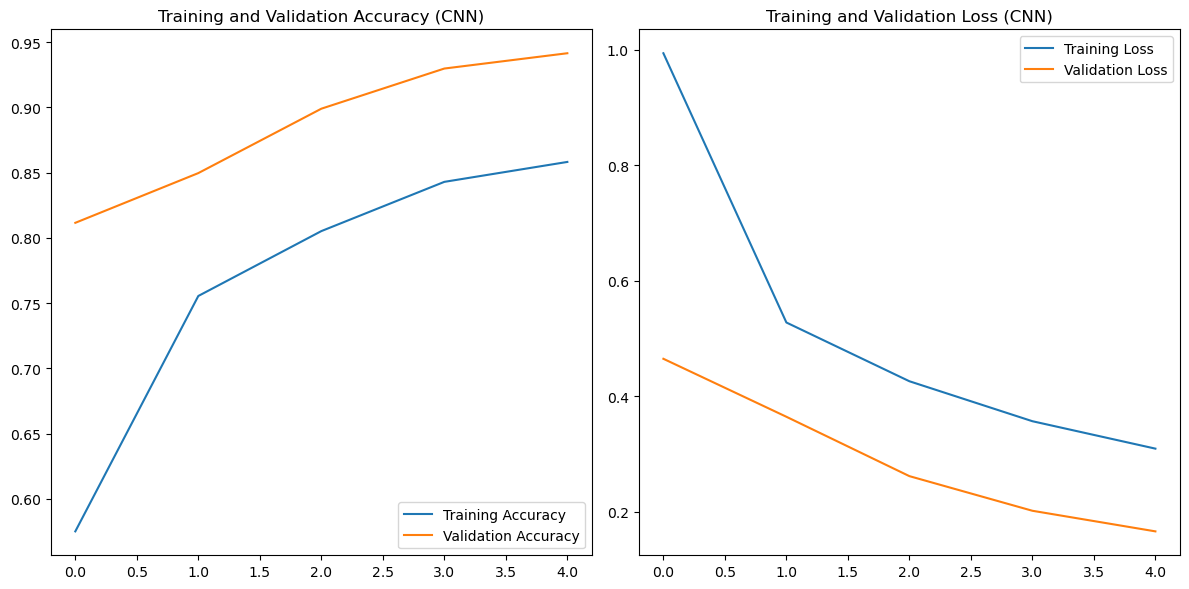

40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 264ms/step - accuracy: 0.8491 - loss: 0.3898

Test Loss (CNN): 0.3898
Test Accuracy (CNN): 84.91%

Overall Test Accuracy (recomputed): 84.91%

Class-wise performance (CNN) in %:
Class                     Support   Precision    Recall   F1-score
Mild Impairment               179      98.10%    57.54%     72.54%
Moderate Impairment            12     100.00%   100.00%    100.00%
No Impairment                 640      84.72%    95.31%     89.71%
Very Mild Impairment          448      81.67%    80.58%     81.12%

Macro-average metrics (CNN) in %:
Precision: 91.12%  Recall: 83.36%  F1-score: 85.84%

Classification Report (sklearn, CNN):
                      precision    recall  f1-score   support

     Mild Impairment       0.98      0.58      0.73       179
 Moderate Impairment       1.00      1.00      1.00        12
       No Impairment       0.85      0.95      0.90       640
Very Mild Impairment       0.82      0.81      0.81       448

            accura

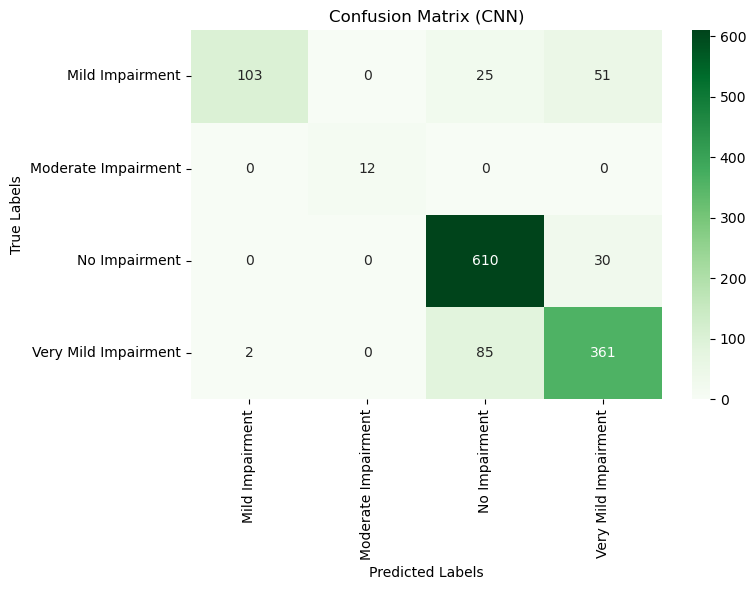

In [11]:
# -----------------------------------------
# Set seed for reproducibility
# -----------------------------------------
seed_value = 42
tf.random.set_seed(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)

num_classes = len(categories)

# -----------------------------------------
# Build the CNN model
# -----------------------------------------
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        # Block 1
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Block 2
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Dense head
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

input_shape = (224, 224, 3)
cnn_model = create_cnn_model(input_shape, num_classes)

cnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\nCNN Model Summary:")
cnn_model.summary()

# -----------------------------------------
# Train the model
# -----------------------------------------
EPOCHS = 5

history = cnn_model.fit(
    train_dataset,
    validation_data=val_dataset,   # use val_dataset, not valid_dataset
    epochs=EPOCHS,
    verbose=1
)

# -----------------------------------------
# Plot Training and Validation Accuracy/Loss
# -----------------------------------------
def plot_training_history(history):
    acc      = history.history['accuracy']
    val_acc  = history.history['val_accuracy']
    loss     = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy (CNN)')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss (CNN)')

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# -----------------------------------------
# Evaluate the model on the TEST dataset
# -----------------------------------------
test_loss, test_accuracy_cnn = cnn_model.evaluate(test_dataset, verbose=1)

print(f"\nTest Loss (CNN): {test_loss:.4f}")
print(f"Test Accuracy (CNN): {test_accuracy_cnn * 100:.2f}%")

# -----------------------------------------
# Classification metrics on TEST set
# -----------------------------------------
y_true_cnn = []
y_pred_cnn = []

for images, labels in test_dataset:
    preds = cnn_model.predict(images, verbose=0)
    y_true_cnn.extend(labels.numpy())
    y_pred_cnn.extend(tf.argmax(preds, axis=1).numpy())

y_true_cnn = np.array(y_true_cnn)
y_pred_cnn = np.array(y_pred_cnn)

# Overall accuracy (for sanity check)
overall_acc = accuracy_score(y_true_cnn, y_pred_cnn)
print(f"\nOverall Test Accuracy (recomputed): {overall_acc * 100:.2f}%")

# Per-class precision, recall, f1 in % with 2 decimals
prec, rec, f1, support = precision_recall_fscore_support(
    y_true_cnn, y_pred_cnn,
    labels=range(num_classes),
    zero_division=0
)

print("\nClass-wise performance (CNN) in %:")
print(f"{'Class':25s} {'Support':>7s}  {'Precision':>10s}  {'Recall':>8s}  {'F1-score':>9s}")
for i, cls_name in enumerate(categories):
    print(
        f"{cls_name:25s} "
        f"{support[i]:7d}  "
        f"{prec[i] * 100:9.2f}%  "
        f"{rec[i] * 100:7.2f}%  "
        f"{f1[i] * 100:8.2f}%"
    )

macro_prec = prec.mean()
macro_rec  = rec.mean()
macro_f1   = f1.mean()

print("\nMacro-average metrics (CNN) in %:")
print(f"Precision: {macro_prec * 100:.2f}%  "
      f"Recall: {macro_rec * 100:.2f}%  "
      f"F1-score: {macro_f1 * 100:.2f}%")

# Sklearn classification report (0–1 scale, but good for reference)
print("\nClassification Report (sklearn, CNN):")
print(classification_report(y_true_cnn, y_pred_cnn, target_names=categories, digits=2))

# -----------------------------------------
# Confusion Matrix Heatmap
# -----------------------------------------
cm = confusion_matrix(y_true_cnn, y_pred_cnn)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=categories,
    yticklabels=categories
)
plt.title('Confusion Matrix (CNN)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()

In [12]:
# ============================================================
# BUILD FEATURE EXTRACTOR FROM CNN
#    (use the Dense(128, relu) layer BEFORE the softmax)
# ============================================================

# We recreate a functional model that passes through all layers
# except the final classification Dense layer.

inputs = tf.keras.Input(shape=(224, 224, 3))
x = inputs
for layer in cnn_model.layers[:-1]:   # skip last Dense(num_classes)
    x = layer(x)

feature_extractor = tf.keras.Model(
    inputs=inputs,
    outputs=x,
    name="cnn_feature_extractor"
)

print("\nFeature extractor summary:")
feature_extractor.summary()

# Check feature shape on one batch
for images, labels in train_dataset.take(1):
    feat_example = feature_extractor(images, training=False)
    print("Example feature batch shape:", feat_example.shape)
    break


# ============================================================
# HELPER: EXTRACT FEATURES FROM A TF.DATA DATASET
# ============================================================

def extract_features_from_dataset(dataset, feature_model):
    all_features = []
    all_labels = []

    for images, labels in dataset:
        feats = feature_model(images, training=False)  # (batch_size, feat_dim)
        all_features.append(feats.numpy())
        all_labels.append(labels.numpy())

    X = np.concatenate(all_features, axis=0)
    y = np.concatenate(all_labels, axis=0)
    return X, y


# ============================================================
# EXTRACT FEATURES FOR TRAIN / VAL / TEST
# ============================================================

print("\nExtracting CNN features for TRAIN set...")
X_train_feats, y_train_feats = extract_features_from_dataset(train_dataset, feature_extractor)
print("TRAIN features shape:", X_train_feats.shape)
print("TRAIN labels shape  :", y_train_feats.shape)

print("\nExtracting CNN features for VAL set...")
X_val_feats, y_val_feats = extract_features_from_dataset(val_dataset, feature_extractor)
print("VAL features shape  :", X_val_feats.shape)
print("VAL labels shape    :", y_val_feats.shape)

print("\nExtracting CNN features for TEST set...")
X_test_feats, y_test_feats = extract_features_from_dataset(test_dataset, feature_extractor)
print("TEST features shape :", X_test_feats.shape)
print("TEST labels shape   :", y_test_feats.shape)

# ============================================================
# COMBINE TRAIN + VAL FOR CLASSICAL ML TRAINING
# ============================================================

X_ml_train = np.concatenate([X_train_feats, X_val_feats], axis=0)
y_ml_train = np.concatenate([y_train_feats, y_val_feats], axis=0)

X_ml_test  = X_test_feats
y_ml_test  = y_test_feats

print("\nFinal shapes for Random Forest / XGBoost:")
print("X_ml_train:", X_ml_train.shape)
print("y_ml_train:", y_ml_train.shape)
print("X_ml_test :", X_ml_test.shape)
print("y_ml_test :", y_ml_test.shape)


Feature extractor summary:


Model: "cnn_feature_extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      23,888,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,907,392 (91.20 MB)

 Trainable params: 23,907,392 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

Example feature batch shape: (32, 128)

Extracting CNN features for TRAIN set...
TRAIN features shape: (8192, 128)
TRAIN labels shape  : (8192,)

Extracting CNN features for VAL set...
VAL features shape  : (2048, 128)
VAL labels shape    : (2048,)

Extracting CNN features for TEST set...
TEST features shape : (1279, 128)
TEST labels shape   : (1279,)

Final shapes for Random Forest / XGBoost:
X_ml_train: (10240, 128)
y_ml_train: (10240,)
X_ml_test : (1279, 128)
y_ml_test : (1279,)



Training Random Forest on CNN features...

Random Forest - Overall Test Accuracy: 91.16%

Class-wise performance (Random Forest) in %:
Class                     Support   Precision    Recall   F1-score
Mild Impairment               179      90.76%    93.30%     92.01%
Moderate Impairment            12     100.00%   100.00%    100.00%
No Impairment                 640      89.88%    95.78%     92.74%
Very Mild Impairment          448      93.27%    83.48%     88.10%

Macro-average metrics (Random Forest) in %:
Precision: 93.48%  Recall: 93.14%  F1-score: 93.21%

Classification Report (Random Forest):
                      precision    recall  f1-score   support

     Mild Impairment       0.91      0.93      0.92       179
 Moderate Impairment       1.00      1.00      1.00        12
       No Impairment       0.90      0.96      0.93       640
Very Mild Impairment       0.93      0.83      0.88       448

            accuracy                           0.91      1279
           macro a

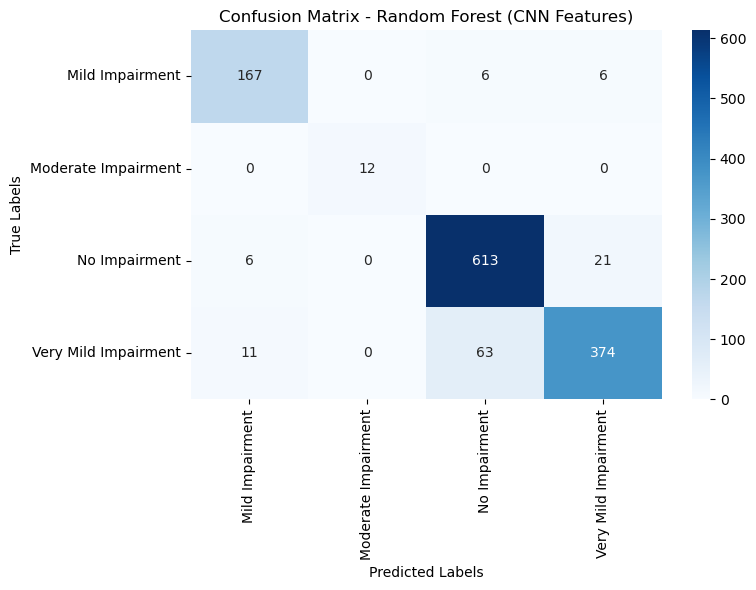

In [13]:
# ============================================================
# RANDOM FOREST CLASSIFIER ON CNN FEATURES
# ============================================================

# Create and train the Random Forest
rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    class_weight="balanced",   # helpful for class imbalance
    n_jobs=-1
)

print("\nTraining Random Forest on CNN features...")
rf_clf.fit(X_ml_train, y_ml_train)

# ============================================================
# PREDICTIONS ON TEST SET
# ============================================================

y_pred_rf = rf_clf.predict(X_ml_test)

# Overall accuracy
acc_rf = accuracy_score(y_ml_test, y_pred_rf)
print(f"\nRandom Forest - Overall Test Accuracy: {acc_rf * 100:.2f}%")

# Per-class precision, recall, f1 (in % with 2 decimals)
prec_rf, rec_rf, f1_rf, support_rf = precision_recall_fscore_support(
    y_ml_test,
    y_pred_rf,
    labels=range(num_classes),
    zero_division=0
)

print("\nClass-wise performance (Random Forest) in %:")
print(f"{'Class':25s} {'Support':>7s}  {'Precision':>10s}  {'Recall':>8s}  {'F1-score':>9s}")
for i, cls_name in enumerate(categories):
    print(
        f"{cls_name:25s} "
        f"{support_rf[i]:7d}  "
        f"{prec_rf[i] * 100:9.2f}%  "
        f"{rec_rf[i] * 100:7.2f}%  "
        f"{f1_rf[i] * 100:8.2f}%"
    )

macro_prec_rf = prec_rf.mean()
macro_rec_rf  = rec_rf.mean()
macro_f1_rf   = f1_rf.mean()

print("\nMacro-average metrics (Random Forest) in %:")
print(f"Precision: {macro_prec_rf * 100:.2f}%  "
      f"Recall: {macro_rec_rf * 100:.2f}%  "
      f"F1-score: {macro_f1_rf * 100:.2f}%")

# ============================================================
# FULL CLASSIFICATION REPORT
# ============================================================

print("\nClassification Report (Random Forest):")
print(classification_report(
    y_ml_test,
    y_pred_rf,
    target_names=categories,
    digits=2
))

# ============================================================
# CONFUSION MATRIX HEATMAP
# ============================================================

cm_rf = confusion_matrix(y_ml_test, y_pred_rf, labels=range(num_classes))

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_rf,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=categories,
    yticklabels=categories
)
plt.title("Confusion Matrix - Random Forest (CNN Features)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()


Training XGBoost on CNN features...

XGBoost - Overall Test Accuracy: 90.70%

Class-wise performance (XGBoost) in %:
Class                     Support   Precision    Recall   F1-score
Mild Impairment               179      89.67%    92.18%     90.91%
Moderate Impairment            12     100.00%   100.00%    100.00%
No Impairment                 640      90.31%    94.69%     92.45%
Very Mild Impairment          448      91.50%    84.15%     87.67%

Macro-average metrics (XGBoost) in %:
Precision: 92.87%  Recall: 92.75%  F1-score: 92.76%

Classification Report (XGBoost):
                      precision    recall  f1-score   support

     Mild Impairment       0.90      0.92      0.91       179
 Moderate Impairment       1.00      1.00      1.00        12
       No Impairment       0.90      0.95      0.92       640
Very Mild Impairment       0.92      0.84      0.88       448

            accuracy                           0.91      1279
           macro avg       0.93      0.93      0

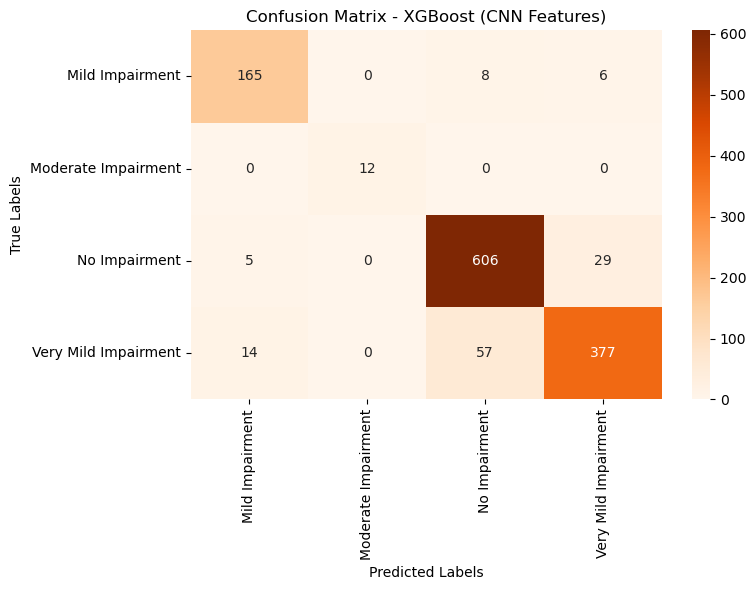

In [14]:
# ============================================================
# XGBOOST CLASSIFIER ON CNN FEATURES
# ============================================================

# Ensure labels are int (just in case)
y_ml_train_int = y_ml_train.astype(int)
y_ml_test_int  = y_ml_test.astype(int)

xgb_clf = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softprob",
    num_class=num_classes,
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1
)

print("\nTraining XGBoost on CNN features...")
xgb_clf.fit(X_ml_train, y_ml_train_int)

# ============================================================
# PREDICTIONS ON TEST SET
# ============================================================

y_pred_xgb = xgb_clf.predict(X_ml_test)

# Overall accuracy
acc_xgb = accuracy_score(y_ml_test_int, y_pred_xgb)
print(f"\nXGBoost - Overall Test Accuracy: {acc_xgb * 100:.2f}%")

# Per-class precision, recall, f1 (in % with 2 decimals)
prec_xgb, rec_xgb, f1_xgb, support_xgb = precision_recall_fscore_support(
    y_ml_test_int,
    y_pred_xgb,
    labels=range(num_classes),
    zero_division=0
)

print("\nClass-wise performance (XGBoost) in %:")
print(f"{'Class':25s} {'Support':>7s}  {'Precision':>10s}  {'Recall':>8s}  {'F1-score':>9s}")
for i, cls_name in enumerate(categories):
    print(
        f"{cls_name:25s} "
        f"{support_xgb[i]:7d}  "
        f"{prec_xgb[i] * 100:9.2f}%  "
        f"{rec_xgb[i] * 100:7.2f}%  "
        f"{f1_xgb[i] * 100:8.2f}%"
    )

macro_prec_xgb = prec_xgb.mean()
macro_rec_xgb  = rec_xgb.mean()
macro_f1_xgb   = f1_xgb.mean()

print("\nMacro-average metrics (XGBoost) in %:")
print(f"Precision: {macro_prec_xgb * 100:.2f}%  "
      f"Recall: {macro_rec_xgb * 100:.2f}%  "
      f"F1-score: {macro_f1_xgb * 100:.2f}%")

# ============================================================
# FULL CLASSIFICATION REPORT
# ============================================================

print("\nClassification Report (XGBoost):")
print(classification_report(
    y_ml_test_int,
    y_pred_xgb,
    target_names=categories,
    digits=2
))

# ============================================================
# CONFUSION MATRIX HEATMAP
# ============================================================

cm_xgb = confusion_matrix(y_ml_test_int, y_pred_xgb, labels=range(num_classes))

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_xgb,
    annot=True,
    fmt="d",
    cmap="Oranges",
    xticklabels=categories,
    yticklabels=categories
)
plt.title("Confusion Matrix - XGBoost (CNN Features)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()


GRU Model Summary:


Model: "gru_image_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 224, 672)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 224, 128)            │         307,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 64)                  │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 349,636 (1.33 MB)

 Trainable params: 349,636 (1.33 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
256/256 ━━━━━━━━━━━━━━━━━━━━ 160s 440ms/step - accuracy: 0.3765 - loss: 1.3073 - val_accuracy: 0.3994 - val_loss: 1.1831
Epoch 2/15
256/256 ━━━━━━━━━━━━━━━━━━━━ 147s 447ms/step - accuracy: 0.4318 - loss: 1.1600 - val_accuracy: 0.5229 - val_loss: 1.0054
Epoch 3/15
256/256 ━━━━━━━━━━━━━━━━━━━━ 148s 436ms/step - accuracy: 0.5394 - loss: 0.9759 - val_accuracy: 0.6426 - val_loss: 0.7830
Epoch 4/15
256/256 ━━━━━━━━━━━━━━━━━━━━ 139s 420ms/step - accuracy: 0.6044 - loss: 0.8252 - val_accuracy: 0.6558 - val_loss: 0.7101
Epoch 5/15
256/256 ━━━━━━━━━━━━━━━━━━━━ 140s 422ms/step - accuracy: 0.6223 - loss: 0.7766 - val_accuracy: 0.6699 - val_loss: 0.6765
Epoch 6/15
256/256 ━━━━━━━━━━━━━━━━━━━━ 141s 430ms/step - accuracy: 0.6407 - loss: 0.7358 - val_accuracy: 0.6821 - val_loss: 0.6505
Epoch 7/15
256/256 ━━━━━━━━━━━━━━━━━━━━ 150s 463ms/step - accuracy: 0.6495 - loss: 0.7132 - val_accuracy: 0.6943 - val_loss: 0.6223
Epoch 8/15
256/256 ━━━━━━━━━━━━━━━━━━━━ 151s 468ms/step - accuracy: 0.6602 -

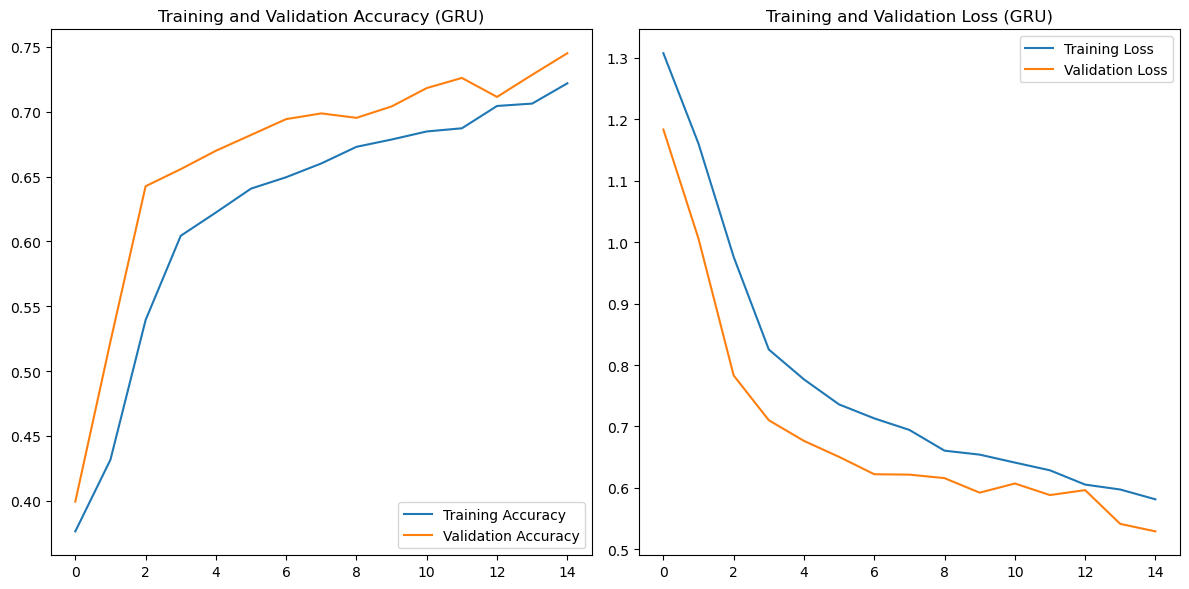

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.5207 - loss: 0.9938

GRU Test Loss: 0.9938
GRU Test Accuracy: 52.07%

Overall Test Accuracy (recomputed, GRU): 52.07%

Class-wise performance (GRU) in %:
Class                     Support   Precision    Recall   F1-score
Mild Impairment               179      62.50%     2.79%      5.35%
Moderate Impairment            12      60.00%    25.00%     35.29%
No Impairment                 640      53.65%    90.78%     67.44%
Very Mild Impairment          448      42.08%    17.19%     24.41%

Macro-average metrics (GRU) in %:
Precision: 54.56%  Recall: 33.94%  F1-score: 33.12%

Classification Report (GRU):
                      precision    recall  f1-score   support

     Mild Impairment       0.62      0.03      0.05       179
 Moderate Impairment       0.60      0.25      0.35        12
       No Impairment       0.54      0.91      0.67       640
Very Mild Impairment       0.42      0.17      0.24       448

            accuracy       

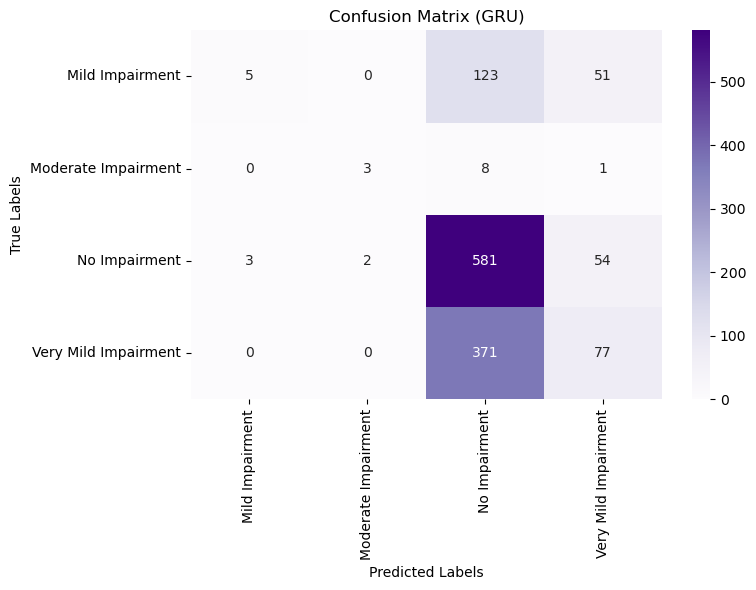

In [15]:
# ------------------------------------------------------
# GRU MODEL ON IMAGE ROW-SEQUENCES
# ------------------------------------------------------

num_classes = len(categories)
input_shape = (224, 224, 3)

def create_gru_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    
    # Reshape image to (timesteps, features)
    # timesteps = 224 (rows), features = 224 * 3
    x = layers.Reshape((input_shape[0], input_shape[1] * input_shape[2]))(inputs)
    
    x = layers.GRU(128, return_sequences=True)(x)
    x = layers.GRU(64)(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    model = models.Model(inputs=inputs, outputs=outputs, name="gru_image_model")
    return model

gru_model = create_gru_model(input_shape, num_classes)

gru_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

print("\nGRU Model Summary:")
gru_model.summary()

# ------------------------------------------------------
# TRAIN GRU MODEL
# ------------------------------------------------------

EPOCHS_GRU = 15

history_gru = gru_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS_GRU,
    verbose=1
)

# ------------------------------------------------------
# PLOT TRAINING / VALIDATION CURVES (GRU)
# ------------------------------------------------------

def plot_gru_history(history):
    acc      = history.history['accuracy']
    val_acc  = history.history['val_accuracy']
    loss     = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy (GRU)')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss (GRU)')

    plt.tight_layout()
    plt.show()

plot_gru_history(history_gru)

# ------------------------------------------------------
# EVALUATE GRU ON TEST DATASET
# ------------------------------------------------------

test_loss_gru, test_acc_gru = gru_model.evaluate(test_dataset, verbose=1)
print(f"\nGRU Test Loss: {test_loss_gru:.4f}")
print(f"GRU Test Accuracy: {test_acc_gru * 100:.2f}%")

# ------------------------------------------------------
# DETAILED METRICS: CLASSIFICATION REPORT & CONFUSION MATRIX
# ------------------------------------------------------

y_true_gru = []
y_pred_gru = []

for images, labels in test_dataset:
    preds = gru_model.predict(images, verbose=0)
    y_true_gru.extend(labels.numpy())
    y_pred_gru.extend(np.argmax(preds, axis=1))

y_true_gru = np.array(y_true_gru)
y_pred_gru = np.array(y_pred_gru)

# Overall accuracy (sanity check)
overall_acc_gru = accuracy_score(y_true_gru, y_pred_gru)
print(f"\nOverall Test Accuracy (recomputed, GRU): {overall_acc_gru * 100:.2f}%")

# Per-class metrics in % with 2 decimals
prec_gru, rec_gru, f1_gru, support_gru = precision_recall_fscore_support(
    y_true_gru, y_pred_gru,
    labels=range(num_classes),
    zero_division=0
)

print("\nClass-wise performance (GRU) in %:")
print(f"{'Class':25s} {'Support':>7s}  {'Precision':>10s}  {'Recall':>8s}  {'F1-score':>9s}")
for i, cls_name in enumerate(categories):
    print(
        f"{cls_name:25s} "
        f"{support_gru[i]:7d}  "
        f"{prec_gru[i] * 100:9.2f}%  "
        f"{rec_gru[i] * 100:7.2f}%  "
        f"{f1_gru[i] * 100:8.2f}%"
    )

macro_prec_gru = prec_gru.mean()
macro_rec_gru  = rec_gru.mean()
macro_f1_gru   = f1_gru.mean()

print("\nMacro-average metrics (GRU) in %:")
print(f"Precision: {macro_prec_gru * 100:.2f}%  "
      f"Recall: {macro_rec_gru * 100:.2f}%  "
      f"F1-score: {macro_f1_gru * 100:.2f}%")

# Sklearn classification report
print("\nClassification Report (GRU):")
print(classification_report(y_true_gru, y_pred_gru, target_names=categories, digits=2))

# Confusion matrix heatmap
cm_gru = confusion_matrix(y_true_gru, y_pred_gru)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_gru,
    annot=True,
    fmt='d',
    cmap='Purples',
    xticklabels=categories,
    yticklabels=categories
)
plt.title('Confusion Matrix (GRU)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()

In [16]:
import numpy as np

# Collect metrics (all in 0–1 scale)
model_metrics = {
    "CNN": {
        "accuracy":  overall_acc,       # or test_accuracy_cnn
        "precision": macro_prec,
        "recall":    macro_rec,
        "f1":        macro_f1
    },
    "Random Forest": {
        "accuracy":  acc_rf,
        "precision": macro_prec_rf,
        "recall":    macro_rec_rf,
        "f1":        macro_f1_rf
    },
    "XGBoost": {
        "accuracy":  acc_xgb,
        "precision": macro_prec_xgb,
        "recall":    macro_rec_xgb,
        "f1":        macro_f1_xgb
    },
    "GRU": {
        "accuracy":  overall_acc_gru,   # or test_acc_gru
        "precision": macro_prec_gru,
        "recall":    macro_rec_gru,
        "f1":        macro_f1_gru
    }
}

# Compute average of all 4 metrics for each model
avg_scores = {}
for name, m in model_metrics.items():
    avg_scores[name] = np.mean([
        m["accuracy"],
        m["precision"],
        m["recall"],
        m["f1"]
    ])

# Print a small summary table
print("\nModel performance summary (all in %):")
print(f"{'Model':15s} {'Acc':>8s} {'Prec':>8s} {'Rec':>8s} {'F1':>8s} {'Avg':>8s}")
for name, m in model_metrics.items():
    avg = avg_scores[name]
    print(
        f"{name:15s} "
        f"{m['accuracy']  * 100:7.2f}% "
        f"{m['precision'] * 100:7.2f}% "
        f"{m['recall']    * 100:7.2f}% "
        f"{m['f1']        * 100:7.2f}% "
        f"{avg            * 100:7.2f}%"
    )

# Pick best model by highest average score
best_model = max(avg_scores, key=avg_scores.get)
print(f"\nBest model overall (by average of accuracy, precision, recall, F1): {best_model}")


Model performance summary (all in %):
Model                Acc     Prec      Rec       F1      Avg
CNN               84.91%   91.12%   83.36%   85.84%   86.31%
Random Forest     91.16%   93.48%   93.14%   93.21%   92.75%
XGBoost           90.70%   92.87%   92.75%   92.76%   92.27%
GRU               52.07%   54.56%   33.94%   33.12%   43.42%

Best model overall (by average of accuracy, precision, recall, F1): Random Forest


# Save the trained Random Forest model
dump(rf_clf, "best_random_forest_model.joblib")

print("Random Forest model saved successfully as best_random_forest_model.joblib")

In [18]:
from joblib import dump
import tensorflow as tf

# 1. Save the feature extractor (Keras)
feature_extractor.save("feature_extractor.keras")
print("Feature extractor saved as feature_extractor.keras")

# 2. Save the Random Forest (you already do this, but keep it here for clarity)
dump(rf_clf, "best_random_forest_model1.joblib")
print("Random Forest model saved as best_random_forest_model1.joblib")

Feature extractor saved as feature_extractor.keras
Random Forest model saved as best_random_forest_model1.joblib


In [39]:
import tensorflow as tf

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(feature_extractor)
tflite_model = converter.convert()

# Save file
with open("feature_extractor.tflite", "wb") as f:
    f.write(tflite_model)

print("Saved feature_extractor.tflite")


INFO:tensorflow:Assets written to: C:\Users\MEERAJ\AppData\Local\Temp\tmptqywbcgm\assets


INFO:tensorflow:Assets written to: C:\Users\MEERAJ\AppData\Local\Temp\tmptqywbcgm\assets


Saved artifact at 'C:\Users\MEERAJ\AppData\Local\Temp\tmptqywbcgm'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_11')
Output Type:
  TensorSpec(shape=(None, 128), dtype=tf.float32, name=None)
Captures:
  2142880311312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2142880307664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2142880306512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2142880308240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2142880306320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2142880312656: TensorSpec(shape=(), dtype=tf.resource, name=None)
Saved feature_extractor.tflite
